# examine properties of WOA in map view

In [6]:
%matplotlib inline
import os
from subprocess import call

from cartopy.util import add_cyclic_point

import matplotlib.pyplot as plt
plt.rcParams['mathtext.default']='regular'
import cmocean

from config_calc import *

import numpy as np
import xarray as xr

import solubility
import plot_tools

fdir = '/glade/p/work/mclong/fig/iucn-ch'
if not os.path.exists(fdir):
    call(['mkdir','-p',fdir])
    
woapth = '/glade/p/ncgd0033/obs/woa2013v2/1x1d'

woa = {
    'O2': {'varname': 'o_an', 'file' : os.path.join(woapth,'woa13_all_o00_01.nc')},   
    'O2sat': {'varname': 'O_an', 'file': os.path.join(woapth,'woa13_all_O00_01.nc')},
    'AOU': {'varname': 'A_an', 'file' : os.path.join(woapth,'woa13_all_A00_01.nc')},    
    'T' : {'varname': 't_an', 'file': os.path.join(woapth,'woa13_decav_t01_01v2.nc')},
    'S' : {'varname': 's_an', 'file': os.path.join(woapth,'woa13_decav_s01_01v2.nc')}}

## compute potential density

## read datasets

In [7]:
ds = {}
for v,info in woa.items():   
    varname = info['varname']
    file_in = info['file']
    dsi = xr.open_dataset(file_in,decode_times=False)
    dsi = dsi.drop([k for k in dsi if k not in [varname,'lat','lon','depth']])
    dsi = dsi.rename({varname:v})
    if ds:
        ds = xr.merge((ds,dsi))
    else:
        ds = dsi
         
ni = len(ds.lon)
nj = len(ds.lat)

mlperl_2_mmolm3 = 1.e6 / 1.e3 / 22.3916
for v in ['O2','AOU']:
    ds[v] = ds[v] * mlperl_2_mmolm3
    ds[v].attrs['units'] = 'mmol m$^{-3}$'
ds

<xarray.Dataset>
Dimensions:  (depth: 102, lat: 180, lon: 360, time: 1)
Coordinates:
  * depth    (depth) float64 0.0 5.0 10.0 15.0 20.0 25.0 30.0 35.0 40.0 45.0 ...
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 ...
Dimensions without coordinates: time
Data variables:
    O2sat    (time, depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    AOU      (time, depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    S        (time, depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    O2       (time, depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    T        (time, depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...

In [8]:
import seawater as sw
na = np.newaxis
pressure = sw.eos80.pres(ds.depth.values[na,:,na,na],ds.lat.values[na,na,:,na])
ds['PD'] = ds['T'].copy()
ds.PD.values = sw.eos80.pden(ds['S'].values,ds['T'].values,pressure,pr=0.)
ds

<xarray.Dataset>
Dimensions:  (depth: 102, lat: 180, lon: 360, time: 1)
Coordinates:
  * depth    (depth) float64 0.0 5.0 10.0 15.0 20.0 25.0 30.0 35.0 40.0 45.0 ...
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 ...
Dimensions without coordinates: time
Data variables:
    O2sat    (time, depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    AOU      (time, depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    S        (time, depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    O2       (time, depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    T        (time, depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    PD       (time, depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...

## compute min O2

In [9]:
ds_min = ds.min(dim='depth').isel(time=0)
print ds_min   

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 ...
Data variables:
    O2sat    (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    AOU      (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    S        (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    O2       (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    T        (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    PD       (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...


[0.0, 5.0, 10.0, 15.0, 20.0, 30.0, 40.0, 50.0, 60.0, 80.0, 100.0]
Blues_r


/glade/p/work/mclong/miniconda2/lib/python2.7/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


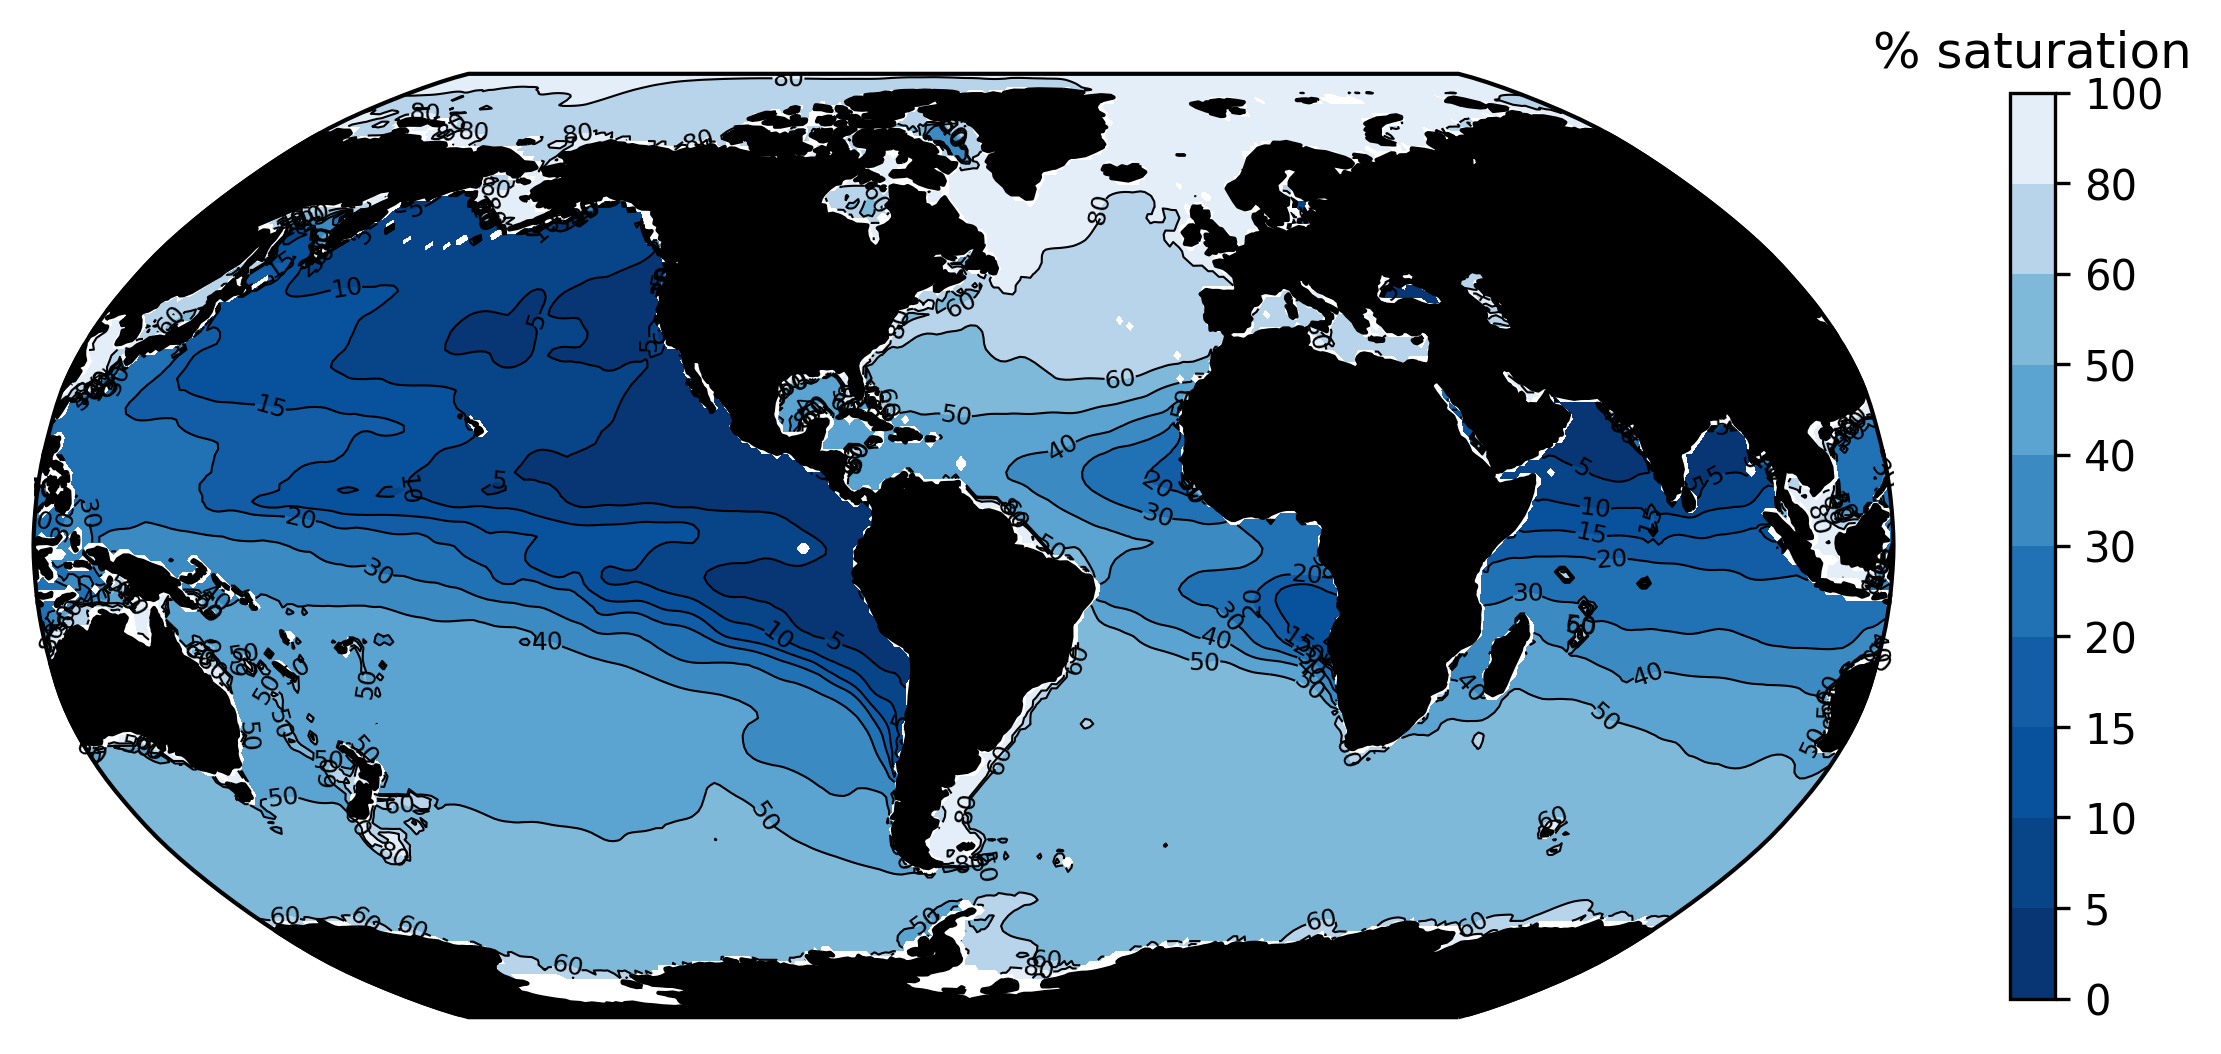

In [10]:
z = ds_min.O2sat.values
lat = ds_min.lat.values
lon = ds_min.lon.values

lon = np.where(lon<0.,lon+360.,lon)
I = np.argsort(lon)
lon = lon[I]
z = z[:,I]
z,lon = add_cyclic_point(z,coord=lon)

#-- set colormap and contours
cmap = 'Blues_r'
units = '% saturation'
levels = [0.,5.,10.,15.,20.,30.,40.,50.,60.,80.,100.]
print levels

print cmap
plot_name = os.path.join(fdir,'woa-column-min-o2-sat.pdf')
plot_tools.plot_map_contour_overlay(lon,lat,z,levels,cmap,units,plot_name)


## compute thermocline: mean between 200-600 m

In [11]:
ds_tc = ds.sel(depth=slice(200.,600.)).mean(dim='depth').isel(time=0)
ds_tc

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 ...
Data variables:
    O2sat    (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    AOU      (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    S        (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    O2       (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    T        (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    PD       (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...

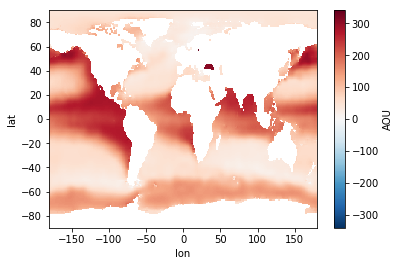

In [12]:
ds_tc.AOU.plot()

[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 80.0, 100.0, 125.0, 150.0, 175.0, 200.0, 225.0, 250.0, 275.0, 300.0]
Blues_r
initial plot size (display units): 6.98,3.54
Adjusting fig size:
	(W,H in): 10.00,4.00 --> 8.03,6.73
new plot size: 5.61,3.57


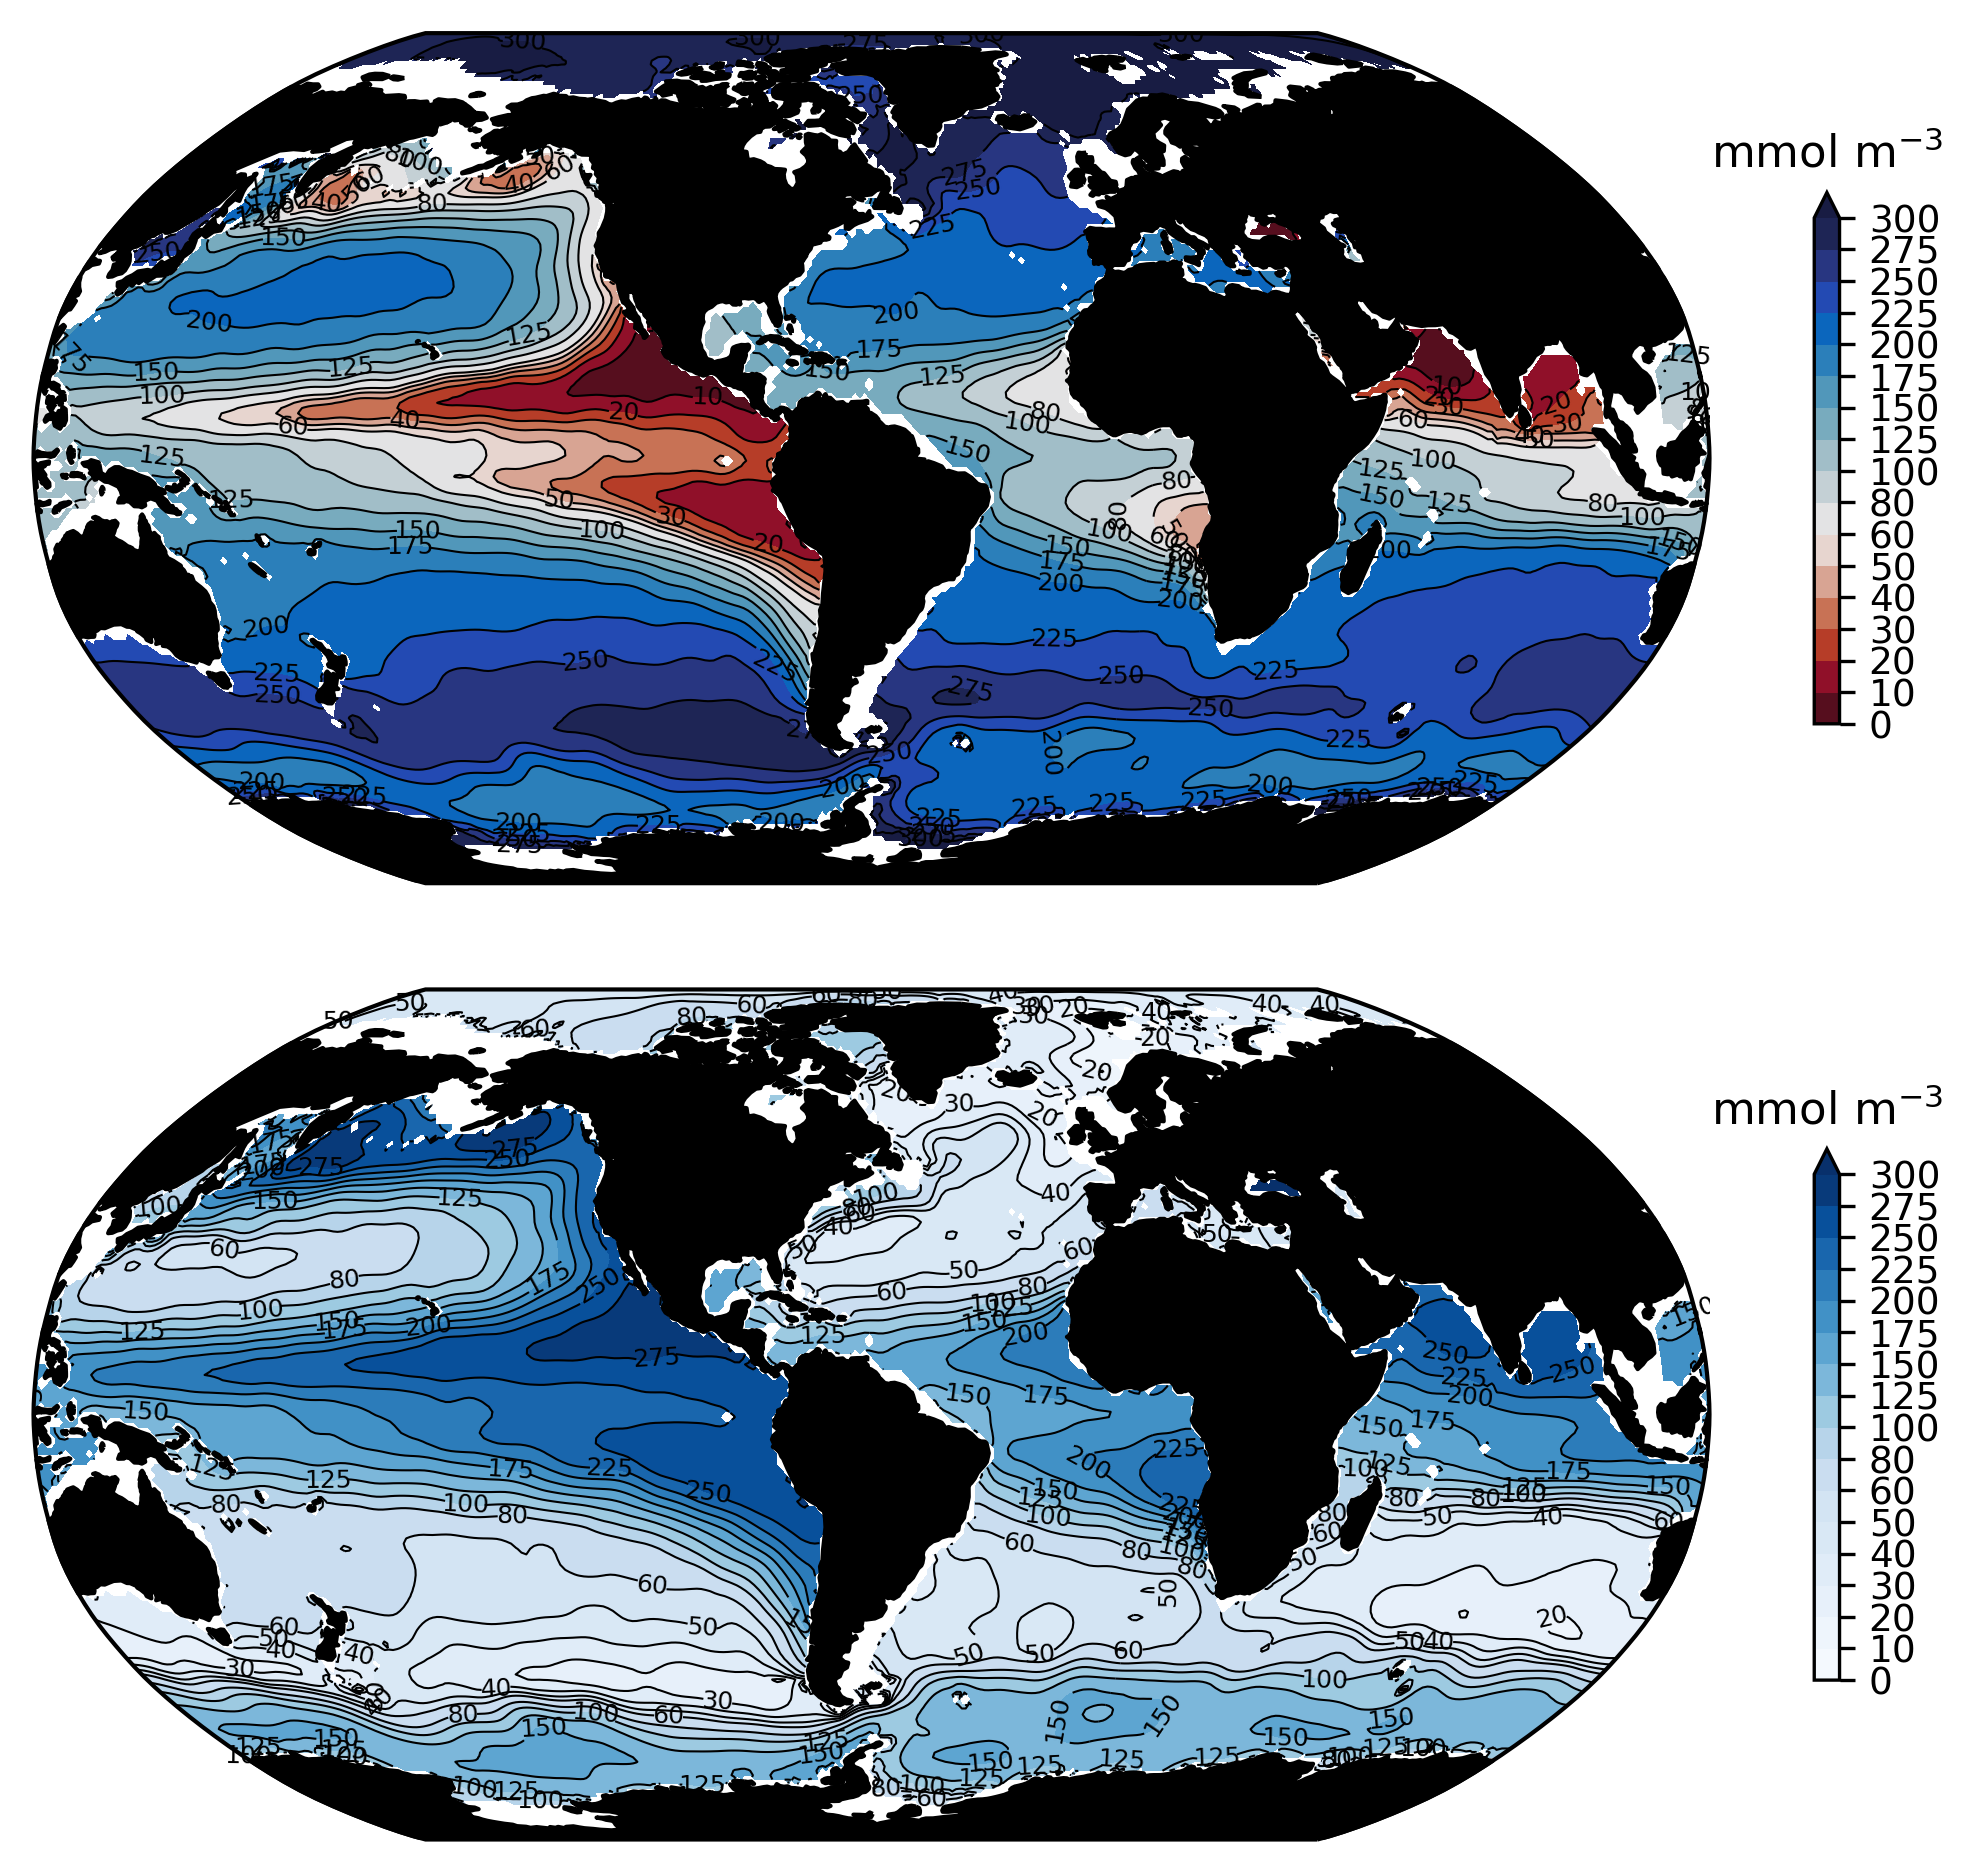

In [15]:
#-- set colormap and contours
import matplotlib.gridspec as gridspec
from cartopy.util import add_cyclic_point
reload(plot_tools)

levels = [0.,10.,20.,30.,40.,50.,60.,80.,100.,125.,150.,175.,200.,225.,250.,275.,300.]
print levels

print cmap
plot_name = os.path.join(fdir,'woa-thermocline-o2-AOU.pdf')

fig=plt.figure(figsize=(10, 4),dpi=300)
gs = gridspec.GridSpec(2,1)

obj = {}
ax = []
for i,v in enumerate(['O2','AOU']):
    lat = ds_tc.lat.values
    lon = ds_tc.lon.values
    z = ds_tc[v].values
    
    lon = np.where(lon<0.,lon+360.,lon)
    I = np.argsort(lon)
    lon = lon[I]
    z = z[:,I]
    z,lon = add_cyclic_point(z,coord=lon)
    
    if v == 'O2':
        norm = plot_tools.MidPointNorm(midpoint=60.)
        contour_specs = {'levels':levels,'cmap':cmocean.cm.balance_r,'norm':norm,'extend':'max'}
    else:
        contour_specs = {'levels':levels,'cmap':'Blues','extend':'max'}

    obj[v] = plot_tools.canvas_map_contour_overlay(lon,lat,z,
                                                   contour_specs,
                                                   units = 'mmol m$^{-3}$',
                                                   fig=fig,
                                                   gridspec=gs,
                                                   row=i,col=0)
    ax.append(obj[v]['ax'])

gridspec_kwargs = {'hspace' : -0.1,
                   'wspace' : 0.05,
                   'left' : 0.,
                   'right' : 0.87,
                   'bottom' : 0.,
                   'top' : 1.}
fgsz = plot_tools.plotgrid(fig, gs, ax, [2,1],gridspec_kwargs)

plt.savefig(plot_name,dpi=300,bbox_inches='tight')

## compute zonal mean

In [ ]:
ds_za = ds.mean(dim='lon').isel(time=0)
ds_za.AOU.plot()
ds_za

In [ ]:
reload(plot_tools)
import matplotlib.gridspec as gridspec

plot_name = os.path.join(diro['fig'],'woa-global-zonal-mean-O2-AOU.pdf')

lat = ds_za.lat
depth = ds_za.depth

fig = plt.figure(dpi=300,figsize=(6,8))

gs = gridspec.GridSpec(2,1)

levels = np.concatenate((np.arange(-80.,0.,5.),np.arange(0.,22.5,2.5)))
levels = [0.,10.,20.,30.,40.,50.,60.,80.,100.,125.,150.,175.,200.,225.,250.,275.,300.]
print levels


#field = np.zeros((len(depth),len(lat)))
obj = {}
for i,v in enumerate(['O2','AOU']):
    field = ds_za[v]

    if v == 'O2':
        norm = plot_tools.MidPointNorm(midpoint=60.)
        contour_specs = {'levels':levels,'cmap':cmocean.cm.balance_r,'norm':norm,'extend':'max'}
    else:
        contour_specs = {'levels':levels,'cmap':'Blues','extend':'both'}
        
    obj[v] = plot_tools.canvas_full_depth_section(lat,depth,field,
                                       fig = fig,
                                       gridspec_spec = gs,
                                       gridspec_index = i,
                                       contour_specs = contour_specs,
                                       xlim = [-78,70])
    cb = fig.colorbar(obj[v]['cf'][0],ax = obj[v]['ax'],
                      ticks = contour_specs['levels'],
                      orientation = 'vertical',
                      shrink = 0.75) 
    cb.ax.set_title('mmol m$^{-3}$',loc='left')

    if i < 1:
        [ax.set_xticklabels([]) for ax in obj[v]['ax']]
        [ax.set_xlabel('') for ax in obj[v]['ax']]

gs.update(left=0.1, right=0.75, wspace=0.08,hspace=0.08)


#obj['O2']['ax'][0].set_title('Total O$_2$ change',loc='left',y=1.02)
#obj['AOU']['ax'][0].set_title('Respiration-driven O$_2$ change',loc='left',y=1.02)
plt.savefig(plot_name,dpi=300,bbox_inches='tight')

In [ ]:
u = ds.sel(depth=slice(0,50)).mean(dim='depth').isel(time=0)
l = ds.sel(depth=slice(100,200)).mean(dim='depth').isel(time=0)

print u
print l
uld = l - u
uld

In [ ]:
uld.PD.plot()

In [ ]:
from cartopy.util import add_cyclic_point
import matplotlib
import matplotlib.gridspec as gridspec
reload(plot_tools)
cmap = cmocean.cm.thermal #'Blues_r'
units = 'kg m$^{-3}$'
levels = [0.,0.1,0.2,0.4,0.6,0.8,1.,1.5,2.,2.5,3.,4.]
print levels

lat = uld.lat.values
lon = uld.lon.values
z = uld.PD.values

lon = np.where(lon<0.,lon+360.,lon)
I = np.argsort(lon)
lon = lon[I]
z = z[:,I]
z,lon = add_cyclic_point(z,coord=lon)
plot_name = os.path.join(diro['fig'],'woa-stratification-map.pdf')


fig=plt.figure(figsize=(10, 8),dpi=300)
gs = gridspec.GridSpec(1,1)

matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

norm = plot_tools.MidPointNorm(midpoint=1.0)
contour_specs = {'levels':levels,'cmap':cmap,'extend':'max','norm':norm}
obj = plot_tools.canvas_map_contour_overlay(lon,lat,z,
                                            contour_specs,
                                            units = units,
                                            fig=fig,
                                            gridspec=gs,
                                            row=0,col=0)
plt.savefig(plot_name,bbox_inches='tight')